In [1]:
!pip install xgboost

In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge,Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.dummy import DummyRegressor 
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from xgboost.plotting import plot_importance
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
 
    


In [4]:
insurance=pd.read_csv('insurance.csv')
insurance.info()
insurance1= pd.read_csv('insurance.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
insurance[['sex', 'smoker', 'region']] = insurance[['sex', 'smoker', 'region']].astype('category')
insurance.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

Converting category labels into numerical using LabelEncoder

In [6]:
label = LabelEncoder()
label.fit(insurance.sex.drop_duplicates())
insurance.sex = label.transform(insurance.sex)
label.fit(insurance.smoker.drop_duplicates())
insurance.smoker = label.transform(insurance.smoker)
label.fit(insurance.region.drop_duplicates())
insurance.region = label.transform(insurance.region)
insurance.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


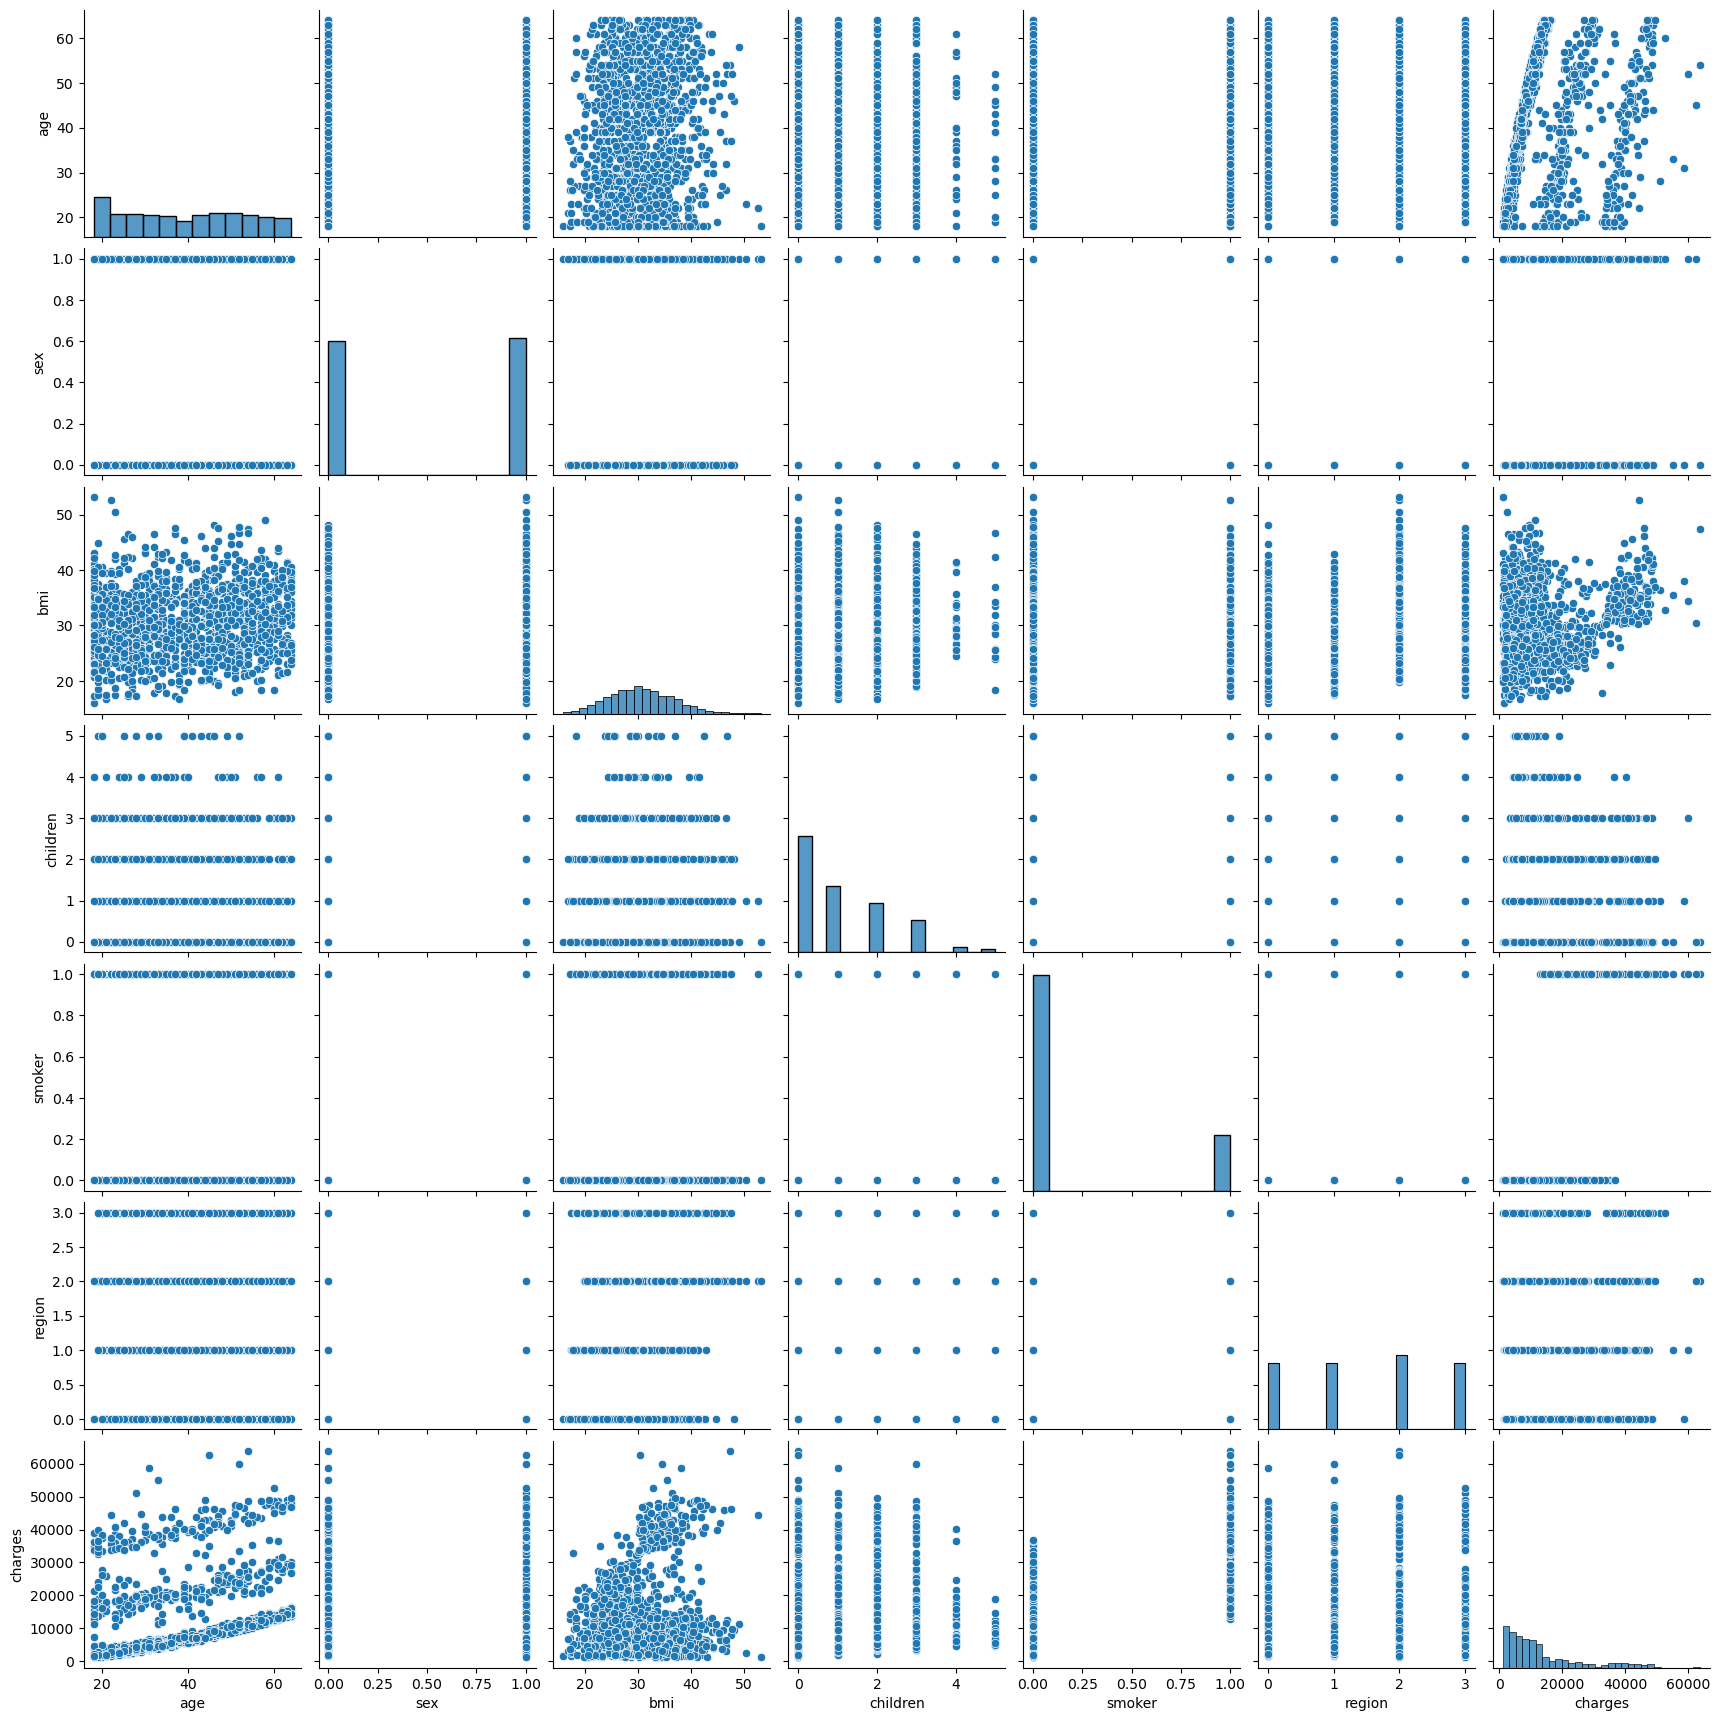

In [7]:
sns.pairplot(insurance)

<Axes: >

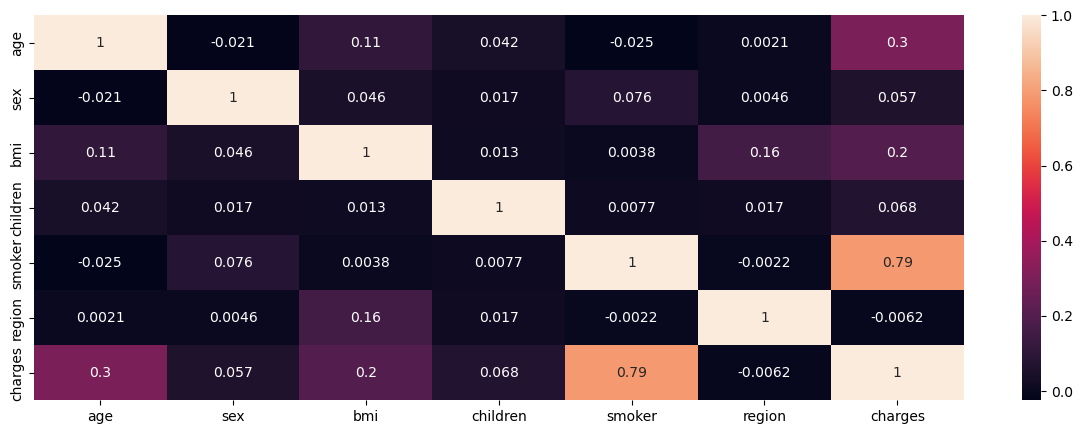

In [8]:
plt.figure(figsize = (15,5))
sns.heatmap(insurance.corr(), annot=True)

In [9]:
numeric_features = ['bmi', 'age', 'children']
transformer = make_column_transformer((StandardScaler(), numeric_features),
                                      remainder = 'passthrough')

Since smoker has the highest score, want to start with basic model with only smoker as input feature. split the data in X and y.

In [10]:
def make_score(model, Xtrain, Xtest, ytrain, ytest):
    
    print(f"MSE on training data is:",mean_squared_error(ytrain, model.predict(Xtrain), squared=False) )
    print(f"MSE on testing data is:", mean_squared_error(ytest, model.predict(Xtest), squared=False))
    print(f"R^2 score on training data is:", model.score(Xtrain, ytrain))
    print(f"R^2 score on test data is:", model.score(Xtest, ytest))

In [11]:
def cv_make_score(model,Xtrain, Xtest, ytrain, ytest):
    MSE_train=np.sqrt(np.abs(cross_val_score(model, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')))
    print(f"MSE on train data with CV=5:",MSE_train)
    MSE_test=np.sqrt(np.abs(cross_val_score(model, Xtest, ytest, cv=5, scoring='neg_mean_squared_error')))
    print(f"MSE on test data with CV=5:",MSE_test)
    model_train_score= cross_val_score(model, Xtrain, ytrain, cv=5)
    model_test_score= cross_val_score(model, Xtest, ytest, cv=5)
    print(f"R^2 on training data is:", model_train_score)
    print(f"R^2 on test data is:", model_test_score)
    print(f"Mean of MSE on training data is:", MSE_train.mean())
    print(f"Mean of MSE on test data is:", MSE_test.mean())
    print(f"Mean of R^2 on training data is:", model_train_score.mean())
    print(f"Mean of R^2 on test data is:", model_test_score.mean())


In [12]:
X1= insurance[['smoker']]
y1= insurance['charges']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=22)

lm=LinearRegression().fit(X1_train, y1_train)
make_score(lm, X1_train, X1_test, y1_train, y1_test)

MSE on training data is: 7539.34706985427
MSE on testing data is: 7170.328436602643
R^2 score on training data is: 0.6116957181452626
R^2 score on test data is: 0.650558280186043


Now with three most important input features without label encoding: Smoker, age, BMI

In [13]:
X2= insurance[['smoker', 'age', 'bmi']]
y2= insurance['charges']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=22)

lm.fit(X2_train, y2_train)
make_score(lm, X2_train, X2_test, y2_train, y2_test)


MSE on training data is: 6100.435271977403
MSE on testing data is: 6027.433886144598
R^2 score on training data is: 0.7457702596632529
R^2 score on test data is: 0.7530769874123803


Now with three most important input features with label encoding: Smoker, age, BMI

In [14]:
insurance[['smoker']] = insurance[['smoker']].astype('category')
insurance.dtypes

label = LabelEncoder()
label.fit(insurance.sex.drop_duplicates())
insurance.sex = label.transform(insurance.sex)
label.fit(insurance.smoker.drop_duplicates())
insurance.smoker = label.transform(insurance.smoker)

numeric_features1 = ['bmi', 'age']
transformer1 = make_column_transformer((StandardScaler(), numeric_features1),
                                      remainder = 'passthrough')

insurance.dtypes
X3= insurance[['smoker', 'age', 'bmi']]
y3= insurance['charges']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2,random_state=22)

#transform the input data
X3_train = transformer1.fit_transform(X3_train)
X3_test = transformer1.transform(X3_test)
lm.fit(X3_train, y3_train)
make_score(lm, X3_train, X3_test, y3_train, y3_test)


MSE on training data is: 6100.435271977404
MSE on testing data is: 6027.433886144589
R^2 score on training data is: 0.7457702596632529
R^2 score on test data is: 0.7530769874123809


Split the data into X and y

In [15]:
X = insurance.drop(['charges'], axis = 1)
y = insurance['charges']

Baseline Model

In [16]:
baseline_preds=np.ones(len(y))*y.mean()
baseline_preds

array([13270.42226514, 13270.42226514, 13270.42226514, ...,
       13270.42226514, 13270.42226514, 13270.42226514])

In [17]:
print("MSE of Baseline model is:", mean_squared_error(y, baseline_preds, squared=False))

MSE of Baseline model is: 12105.484975561612


Mean of target variable

In [18]:
print("Mean of target variable is:", y.mean())

Mean of target variable is: 13270.422265141257


Split the data into training and test data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=22)

In [20]:
#transform the input data
#X_train = transformer.fit_transform(X_train)
#X_test = transformer.transform(X_test)

Now to determine the baseline performance for a Regression model using the DummyRegressor on the training data. 
and finding the baseline accuracy? Assigning the baseline training accuracy as a float to baseline.
First we will consider R^2 since thats the default value. Then mean and median.

DummyRegressor Model

In [21]:
base_model_dummy = DummyRegressor()
base_model_dummy.fit(X_train, y_train)
baseline = base_model_dummy.score(X_train, y_train)
print("Dummy Regressor model R^2 score:", baseline)

base_model_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train) 
base_model_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train) 
y_predict_dummy_mean = base_model_dummy_mean.predict(X_test) 
y_predict_dummy_median = base_model_dummy_median.predict(X_test) 
 
print("MSE on test data (dummy) is: {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean, squared=False))) 
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median))) 
print("R^2 score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean))) 
print("R^2 score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median))) 

Dummy Regressor model R^2 score: 0.0
MSE on test data (dummy) is: 12132.00
Median absolute error (dummy): 5090.19
R^2 score (dummy mean): -0.00
R^2 score (dummy median): -0.12


Dummy Regressor with mean squared error and cross validation:

In [22]:
print("The average mean squared error for the Dummy Regressor is:")
np.sqrt(np.abs(cross_val_score(base_model_dummy, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))).mean()


The average mean squared error for the Dummy Regressor is:


12099.694541626344

Score (X, y, sample_weight=None)
Return the coefficient of determination R^2 of the prediction.
The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
A constant model that always predicts the expected value of y, disregarding the input features, 
would get a R^2 score of 0.0.

Linear Regression model:

In [23]:
print("Statistics of Linear Regression model: ")
lm.fit(X_train, y_train)
make_score(lm, X_train, X_test, y_train, y_test)

Statistics of Linear Regression model: 
MSE on training data is: 6066.3212624073685
MSE on testing data is: 5970.444717472253
R^2 score on training data is: 0.7486056463218349
R^2 score on test data is: 0.7577242096466302


OBSERVATIONS: 
As can be seen from the above result. The expected Dummy Regressor always predict the r2_ score 
as 0 for both the mean and median (0 and -0.12), since it is always predicting a constant without having an 
insight of the output. ( In general, best r2_score is 1 and Constant r2_score is 0). 
The Linear Regression Model seems to fit a little better than the Dummy Regressor in terms of “mean squared error”,
“median absolute error” and “r2_score”. 
https://www.geeksforgeeks.org/dummy-regressor/

Linear Regression with Cross validation and R^2

In [24]:
print("Statistics of Linear Regression model with cv=5: ")
cv_make_score(lm, X_train, X_test, y_train, y_test)

Statistics of Linear Regression model with cv=5: 
MSE on train data with CV=5: [6736.18319773 6327.56648077 5156.93047458 5831.85349125 6476.04603912]
MSE on test data with CV=5: [4519.886668   7182.28299889 5984.55629623 6110.8285228  6219.77518775]
R^2 on training data is: [0.75408355 0.7172788  0.77803097 0.71799588 0.73245679]
R^2 on test data is: [0.83348179 0.74312312 0.67324177 0.70655995 0.77226494]
Mean of MSE on training data is: 6105.7159366882925
Mean of MSE on test data is: 6003.46593473572
Mean of R^2 on training data is: 0.739969196401294
Mean of R^2 on test data is: 0.7457343158771967


Ridge Regression model:

In [25]:
print("Statistics of Ridge model: ")
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
make_score(ridge, X_train, X_test, y_train, y_test)


Statistics of Ridge model: 
MSE on training data is: 6066.3817374493765
MSE on testing data is: 5973.0110339500825
R^2 score on training data is: 0.7486006340057305
R^2 score on test data is: 0.7575158868133229


Ridge Model with CV=5

In [26]:
print("Statistics of Ridge model with cv=5: ")
cv_make_score(ridge, X_train, X_test, y_train, y_test)

Statistics of Ridge model with cv=5: 
MSE on train data with CV=5: [6744.07870001 6326.52802376 5157.71014495 5825.7691689  6473.70575712]
MSE on test data with CV=5: [4513.98378746 7213.70210452 5979.98577267 6113.39434921 6208.60273622]
R^2 on training data is: [0.75350673 0.71737159 0.77796384 0.718584   0.73265012]
R^2 on test data is: [0.83391644 0.74087078 0.67374068 0.70631348 0.77308236]
Mean of MSE on training data is: 6105.558358948903
Mean of MSE on test data is: 6005.933750015291
Mean of R^2 on training data is: 0.7400152564671088
Mean of R^2 on test data is: 0.7455847490144913


Polynomial Features

In [27]:
X = insurance.drop(['charges'], axis = 1)
y = insurance['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=22)

In [28]:
pipe = Pipeline(steps=[('poly', PolynomialFeatures()),
                        ('classifier', lm)])

In [29]:
print("Statistics of Polynomial Features model with cv=5: ")
cv_make_score(pipe, X_train, X_test, y_train, y_test)

Statistics of Polynomial Features model with cv=5: 
MSE on train data with CV=5: [5409.22917587 5070.66210432 3724.63214149 4520.8181841  5113.975651  ]
MSE on test data with CV=5: [3370.8674516  6260.84937976 5500.9112084  5348.6900154  5580.75922157]
R^2 on training data is: [0.84142652 0.81844246 0.88420852 0.83053644 0.83316338]
R^2 on test data is: [0.90738315 0.80480599 0.72392194 0.77519082 0.81665584]
Mean of MSE on training data is: 4767.863451358664
Mean of MSE on test data is: 5212.4154553456
Mean of R^2 on training data is: 0.8415554623689282
Mean of R^2 on test data is: 0.8055915469128733


Grid Search with Ploynomial Features

In [30]:
params = {'poly__degree': [1,2,3,4,5,6,7]}
grid=GridSearchCV(pipe, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
grid.best_estimator_
print("Best Estimator:", grid.best_params_)
print("Best score:", np.sqrt(np.abs(grid.best_score_)))
pd.DataFrame(grid.cv_results_)

Best Estimator: {'poly__degree': 2}
Best score: 4804.889240253629


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002588,0.000542,0.000728,0.000244,1,{'poly__degree': 1},-4.537616e+07,-4.003810e+07,-2.659393e+07,-3.401052e+07,-4.193917e+07,-3.759158e+07,6.622070e+06,4
1,0.002449,0.000903,0.000971,0.000285,2,{'poly__degree': 2},-2.925976e+07,-2.571161e+07,-1.387288e+07,-2.043780e+07,-2.615275e+07,-2.308696e+07,5.409410e+06,1
2,0.005296,0.000489,0.001118,0.000159,3,{'poly__degree': 3},-3.183980e+07,-3.043526e+07,-1.616803e+07,-2.220704e+07,-2.738485e+07,-2.560700e+07,5.761501e+06,2
3,0.012095,0.001469,0.000939,0.000421,4,{'poly__degree': 4},-3.335502e+07,-2.949647e+07,-2.464087e+07,-2.850669e+07,-3.296450e+07,-2.979271e+07,3.194789e+06,3
4,0.044879,0.002822,0.000784,0.000152,5,{'poly__degree': 5},-7.430026e+07,-1.048492e+08,-1.181055e+08,-3.872253e+08,-7.280967e+07,-1.514580e+08,1.191720e+08,5
5,0.153382,0.001027,0.001703,0.000626,6,{'poly__degree': 6},-8.748958e+11,-4.951641e+11,-2.597717e+10,-7.461261e+13,-7.790638e+09,-1.520329e+13,2.970641e+13,6
6,0.242658,0.008984,0.003415,0.002729,7,{'poly__degree': 7},-1.245347e+14,-3.696724e+12,-2.327206e+13,-3.632950e+12,-4.935321e+12,-3.201435e+13,4.685532e+13,7


Now let’s take that grid model and create some predictions using the test set and create regression matrices for them. Let‘s inspect the differences in a DataFrame. First, we concatenate the true and predicted y:

In [31]:
grid_pred = grid.predict(X_test)
y_valid = y_test.copy()
gg = []
for i in grid_pred:
 gg.append(i)
gf = pd.DataFrame(data=gg)
gf = gf.set_index(y_valid.index)
gf.rename(columns={0: "predicted"}, inplace=True)
df321 = pd.concat([y_valid, gf], axis=1)
df321.columns = ["Y_true", "Y_pred"]
df321.head()

,Y_true,Y_pred
1231,20167.33603,13896.259766
768,14319.03100,14937.904053
847,2438.05520,1779.103271
510,11763.00090,13720.580811
363,2597.77900,3775.863770


And compute the difference score, which will show us if more values are positive or negative:

In [32]:
df321["diff"] = df321["Y_pred"]- df321["Y_true"]
df321.head()


,Y_true,Y_pred,diff
1231,20167.33603,13896.259766,-6271.076264
768,14319.03100,14937.904053,618.873053
847,2438.05520,1779.103271,-658.951929
510,11763.00090,13720.580811,1957.579911
363,2597.77900,3775.863770,1178.084770


There is a tendency for the y_true values being overestimated, as we can see in the histogram:

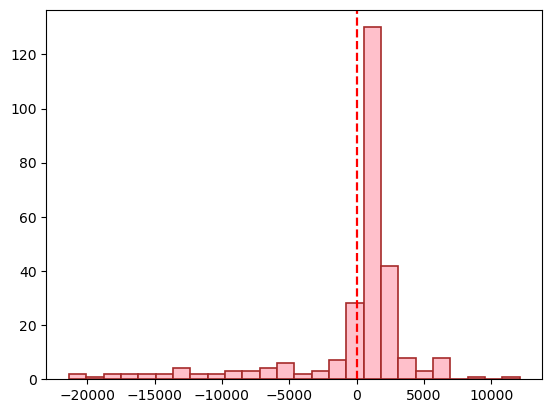

In [33]:
plt.hist(df321["diff"], bins=26, color="pink", edgecolor="brown", linewidth=1.2)
plt.axvline(0, color="red", linestyle="dashed", linewidth=1.6)
plt.show()

In [34]:
pd.DataFrame({"Count": [(df321["diff"]<0).sum(), 
                        (df321["diff"]==0).sum(),
                        (df321["diff"]>0).sum()]}, 
columns=["Count"],index=["Underestimation", "Exact Estimation", "Overestimation"])

,Count
Underestimation,61
Exact Estimation,0
Overestimation,207


In [35]:
pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                        ('classifier', lm)])
print("Statistics of Polynomial Features model with cv=5 and degree=2: ")
cv_make_score(pipe, X_train,X_test, y_train, y_test)

Statistics of Polynomial Features model with cv=5 and degree=2: 
MSE on train data with CV=5: [5409.22917587 5070.66210432 3724.63214149 4520.8181841  5113.975651  ]
MSE on test data with CV=5: [3370.8674516  6260.84937976 5500.9112084  5348.6900154  5580.75922157]
R^2 on training data is: [0.84142652 0.81844246 0.88420852 0.83053644 0.83316338]
R^2 on test data is: [0.90738315 0.80480599 0.72392194 0.77519082 0.81665584]
Mean of MSE on training data is: 4767.863451358664
Mean of MSE on test data is: 5212.4154553456
Mean of R^2 on training data is: 0.8415554623689282
Mean of R^2 on test data is: 0.8055915469128733


Now get rid of unwanted features

In [36]:
XR = insurance.drop(['charges', 'sex', 'region', 'children'], axis = 1)
yr = insurance.charges



Split the data

In [37]:
XR_train, XR_test, yr_train, yr_test = train_test_split(XR, yr, test_size=0.2, random_state=0)

In [38]:
pipe = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                        ('classifier', lm)])

pipe.fit(XR_train, yr_train)
print("Statistics of Polynomial Features model with cv=5 and reduced features: ")
MSE_train=np.sqrt(np.abs(cross_val_score(pipe, XR_train, yr_train, cv=5, scoring='neg_mean_squared_error')))
print(f"MSE on train data with CV=5:",MSE_train)
MSE_test=np.sqrt(np.abs(cross_val_score(pipe, XR_test, yr_test, cv=5, scoring='neg_mean_squared_error')))
print(f"MSE on test data with CV=5:",MSE_test)
pipe_train_score= cross_val_score(pipe, XR_train, yr_train, cv=5)
pipe_test_score= cross_val_score(pipe, XR_test, yr_test, cv=5)
print(f"R^2 on training data is:", pipe_train_score)
print(f"R^2 on test data is:", pipe_test_score)
print(f"Mean of MSE on training data is:", MSE_train.mean())
print(f"Mean of MSE on test data is:", MSE_test.mean())
print(f"Mean of R^2 on training data is:", pipe_train_score.mean())
print(f"Mean of R^2 on test data is:", pipe_test_score.mean())


Statistics of Polynomial Features model with cv=5 and reduced features: 
MSE on train data with CV=5: [4723.56420002 4476.67379871 4817.00776247 4730.95826359 6108.28377529]
MSE on test data with CV=5: [5410.98344297 4213.36288184 4185.53104258 5224.21128805 2950.59728691]
R^2 on training data is: [0.85812025 0.82669669 0.82369919 0.84713261 0.76900463]
R^2 on test data is: [0.84212914 0.90315876 0.89675216 0.77079484 0.9264583 ]
Mean of MSE on training data is: 4971.29756001625
Mean of MSE on test data is: 4396.937188470042
Mean of R^2 on training data is: 0.8249306758066185
Mean of R^2 on test data is: 0.8678586399573291


PCA

In [39]:
poly= PolynomialFeatures(degree=7)
XP= poly.fit_transform(X)
print(XP.shape)
lm.fit(XP,y)   #No need for this, just for understanding
print(lm.score(XP,y)) #no need for this either

(1338, 1716)
0.9274343169805924


In [40]:
pca = PCA(n_components=20)
xpca = pca.fit_transform(XP)  # Need to apply PCA on this data
xpca.shape


(1338, 20)

In [41]:
# pipe2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
#                         ('pca', PCA(10)),
#                         ('model', lm)])
# pipe2_mse=np.sqrt(np.abs(cross_val_score(pipe2, xpca, y, cv=5, scoring='neg_mean_squared_error')))
# print("MSE of Polynomial Features model with PCA is:", pipe2_mse)
# print("Average MSE of Polynomial Features model with PCA is:", pipe2_mse.mean())


In [42]:
pipe2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('pca', PCA()),
                        ('model', lm)])
params2= {'pca__n_components': [1,3,5,6,7,10,11,100]}
grid2=GridSearchCV(pipe2, param_grid= params2, cv=5, scoring='neg_mean_squared_error')
grid2.fit(xpca,y)
grid2.best_estimator_
print("Best Estimator:", grid2.best_params_)
print("Best score:", np.sqrt(np.abs(grid2.best_score_)))
pd.DataFrame(grid2.cv_results_)

Best Estimator: {'pca__n_components': 10}
Best score: 11077.78978855326


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013493,0.004097,0.001190,0.000392,1,{'pca__n_components': 1},-1.448509e+08,-1.229990e+08,-1.476442e+08,-1.485986e+08,-1.453495e+08,-1.418884e+08,9.546941e+06,6
1,0.008846,0.000147,0.000896,0.000418,3,{'pca__n_components': 3},-1.468867e+08,-1.231785e+08,-1.484189e+08,-1.488176e+08,-1.461311e+08,-1.426866e+08,9.803254e+06,7
2,0.008886,0.000415,0.000904,0.000361,5,{'pca__n_components': 5},-1.429110e+08,-1.242169e+08,-1.443290e+08,-1.477106e+08,-1.440988e+08,-1.406532e+08,8.371856e+06,3
3,0.009079,0.000972,0.001005,0.000418,6,{'pca__n_components': 6},-1.432262e+08,-1.244634e+08,-1.455577e+08,-1.447945e+08,-1.483180e+08,-1.412720e+08,8.564675e+06,5
4,0.010569,0.001960,0.000785,0.000333,7,{'pca__n_components': 7},-1.425644e+08,-1.257765e+08,-1.434629e+08,-1.451657e+08,-1.471467e+08,-1.408232e+08,7.684375e+06,4
5,0.011385,0.000843,0.000899,0.000477,10,{'pca__n_components': 10},-1.175316e+08,-1.018306e+08,-1.309405e+08,-1.347112e+08,-1.285731e+08,-1.227174e+08,1.190722e+07,1
6,0.012075,0.001588,0.000695,0.000376,11,{'pca__n_components': 11},-1.174745e+08,-1.019037e+08,-1.304487e+08,-1.353030e+08,-1.287073e+08,-1.227674e+08,1.195604e+07,2
7,0.029520,0.002947,0.001006,0.000411,100,{'pca__n_components': 100},-3.078617e+07,-4.917647e+07,-1.387543e+08,-3.876335e+08,-1.084970e+09,-3.382641e+08,3.944427e+08,8


Since best PCA n_components comes out to be 10 from GridSearchCV, we can apply that on pipe2. 

In [43]:
pipe2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('pca', PCA(10)),
                        ('model', lm)])
pipe2_mse=np.sqrt(np.abs(cross_val_score(pipe2, xpca, y, cv=5, scoring='neg_mean_squared_error')))
print("MSE of Polynomial Features model with PCA is:", pipe2_mse)
print("Average MSE of Polynomial Features model with PCA is:", pipe2_mse.mean())


MSE of Polynomial Features model with PCA is: [10841.20118261 10091.11728764 11442.92308633 11606.51711045
 11339.00849312]
Average MSE of Polynomial Features model with PCA is: 11064.153432032359


In [44]:
# numeric_features1 = ['bmi', 'age', 'children']
# numeric_transformer1 = Pipeline([('scaler', StandardScaler())])

# categorical_features1 = ['smoker']
# categorical_transformer1 = Pipeline([('onehot', OneHotEncoder(drop='first'))])


# transformer1 = ColumnTransformer(transformers=[
# ('num', numeric_transformer, numeric_features),
# ('cat', categorical_transformer1, categorical_features1)])

# x=transformer1.fit_transform(x)


# pol = PolynomialFeatures ()
# x_pol = pol.fit_transform(XR)
# x_train, x_test, y_train, y_test = train_test_split(x_pol, yr, test_size=0.2, random_state=0)
# Pol_reg = LinearRegression()
# Pol_reg.fit(x_train, y_train)
# y_train_pred = Pol_reg.predict(x_train)
# y_test_pred = Pol_reg.predict(x_test)
# print(Pol_reg.intercept_)
# print(Pol_reg.coef_)
# print(Pol_reg.score(x_test, y_test))




DecisionTrees:

In [45]:
XD = insurance.drop(['charges'], axis = 1)
yD = insurance['charges']
XD_train, XD_test, yD_train, yD_test = train_test_split(XD, yD, test_size=0.2,random_state=22)
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(XD_train, yD_train)
make_score(tree, XD_train, XD_test, yD_train, yD_test)
#y_pred = tree.predict(data_test)

MSE on training data is: 4471.38776591854
MSE on testing data is: 5222.981148973292
R^2 score on training data is: 0.8634192870453702
R^2 score on test data is: 0.8145898211141788


In [46]:
cv_make_score(tree, XD_train, XD_test, yD_train, yD_test )

MSE on train data with CV=5: [4887.430102   5169.47611306 3508.05459993 4399.49619476 5076.54677497]
MSE on test data with CV=5: [3892.86162273 6429.27661473 4722.68756104 6077.6505657  4689.00227868]
R^2 on training data is: [0.87054438 0.81129735 0.89728295 0.83950994 0.83559657]
R^2 on test data is: [0.87647793 0.79416264 0.79651095 0.70973769 0.87056808]
Mean of MSE on training data is: 4608.2007569430325
Mean of MSE on test data is: 5162.295728576496
Mean of R^2 on training data is: 0.8508462377208297
Mean of R^2 on test data is: 0.8094914559279417


In [47]:
depths = list(range(1, 21))
print(depths)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Fine tuning of Depth of tree:

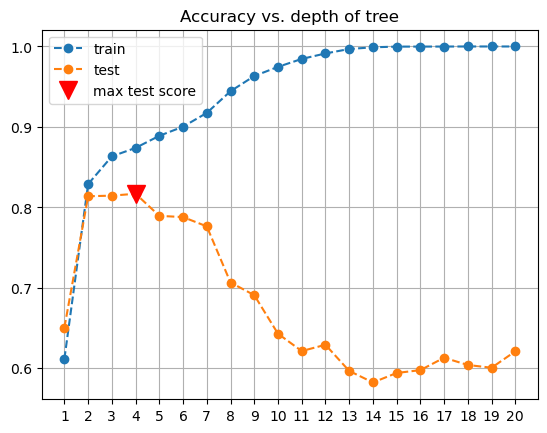

In [48]:
tree = DecisionTreeRegressor(random_state=0)
train_scores = []
test_scores = []
for depth in depths:
    tree=DecisionTreeRegressor(max_depth=depth).fit(XD_train, yD_train)
    train_scores.append(tree.score(XD_train, yD_train))
    test_scores.append(tree.score(XD_test, yD_test))
                     
plt.plot(depths, train_scores, '--o', label = 'train')
plt.plot(depths, test_scores, '--o', label = 'test')
plt.title('Accuracy vs. depth of tree')
plt.xticks(depths)
plt.plot(np.argmax(test_scores)+1, max(test_scores), 
         'v', markersize = 13, color = 'red',
        label = 'max test score')
plt.legend()
plt.grid();

Fine tuning of alpha

In [49]:
alphas = [0, 0.001, 0.01, 1, 10]

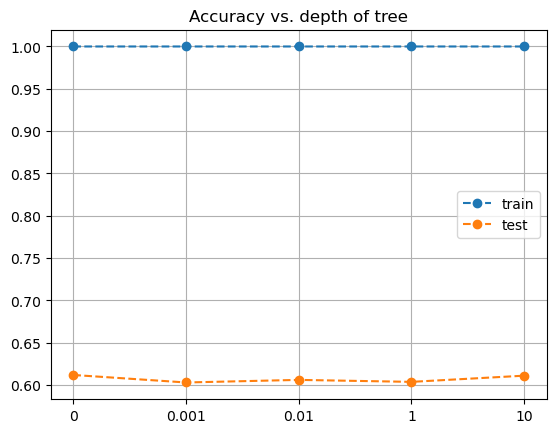

In [50]:
ccp_train_scores = []
ccp_test_scores = []
for alpha in alphas:
    tree = DecisionTreeRegressor(ccp_alpha=alpha)
    tree.fit(XD_train, yD_train)
    ccp_train_scores.append(tree.score(XD_train, yD_train))
    ccp_test_scores.append(tree.score(XD_test, yD_test))
    
#Answer test                     
plt.plot(range(len(alphas)), ccp_train_scores, '--o', label = 'train')
plt.plot(range(len(alphas)), ccp_test_scores, '--o', label = 'test')
plt.title('Accuracy vs. depth of tree') #it should say accuracy vs ccp_alpha value
plt.xticks(range(len(alphas)), alphas)
plt.legend()
plt.grid();

Plotting Feature Importance

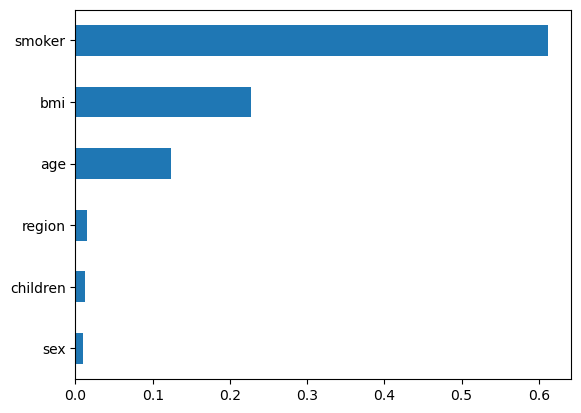

In [51]:
tree = DecisionTreeRegressor(ccp_alpha=.01).fit(XD_train, yD_train)
importances = {k:v for k,v in zip(XD_train.columns, tree.feature_importances_)}
pd.Series(importances).sort_values().plot(kind = 'barh');

BaggingRegressor

In [52]:
Xb = insurance.drop(['charges'], axis = 1)
yb = insurance['charges']
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2,random_state=22)



#default settings
bagging_default = BaggingRegressor(DecisionTreeRegressor(max_depth=4), 
                           n_estimators=100,
                                   random_state = 22)
#prepruned trees with max_depth
bagging_preprune = BaggingRegressor(DecisionTreeRegressor(max_depth=4), 
                           n_estimators=100,
                                    random_state = 22)

#post pruned trees with ccp_alpha
bagging_postprune = BaggingRegressor(DecisionTreeRegressor(ccp_alpha=0.001),
                                     n_estimators=100,
                                     random_state = 22)
print("Statistics of Default Bagging Regressor model: ")
bagging_default.fit(Xb_train, yb_train)
make_score(bagging_default, Xb_train, Xb_test, yb_train, yb_test)

print("Statistics of Preprune Bagging Regressor model: ")
bagging_preprune.fit(Xb_train, yb_train)
make_score(bagging_preprune, Xb_train, Xb_test, yb_train, yb_test)

print("Statistics of Postprune Bagging Regressor model: ")
bagging_postprune.fit(Xb_train, yb_train)
make_score(bagging_postprune, Xb_train, Xb_test, yb_train, yb_test)


Statistics of Default Bagging Regressor model: 
MSE on training data is: 4150.348507059669
MSE on testing data is: 4969.674408399918
R^2 score on training data is: 0.8823278091400835
R^2 score on test data is: 0.8321379473975566
Statistics of Preprune Bagging Regressor model: 
MSE on training data is: 4150.348507059669
MSE on testing data is: 4969.674408399918
R^2 score on training data is: 0.8823278091400835
R^2 score on test data is: 0.8321379473975566
Statistics of Postprune Bagging Regressor model: 
MSE on training data is: 1804.4628141155345
MSE on testing data is: 5174.993830114039
R^2 score on training data is: 0.9777566302931199
R^2 score on test data is: 0.8179811656253269


In [53]:
temp=bagging_default.score(Xb_test, yb_test)
temp1=bagging_preprune.score(Xb_test, yb_test)
temp2=bagging_postprune.score(Xb_test, yb_test)
print("Score of bagging regressor is: ", temp, temp1, temp2)
print("Statistics of Default Bagging Regressor model with CV=5: ")
cv_make_score(bagging_default, Xb_train, Xb_test, yb_train, yb_test)
print("Statistics of Preprune Bagging Regressor model with CV=5: ")
cv_make_score(bagging_preprune, Xb_train, Xb_test, yb_train, yb_test)
print("Statistics of Postprune Bagging Regressor model with CV=5: ")
cv_make_score(bagging_postprune, Xb_train, Xb_test, yb_train, yb_test)


Score of bagging regressor is:  0.8321379473975566 0.8321379473975566 0.8179811656253269
Statistics of Default Bagging Regressor model with CV=5: 
MSE on train data with CV=5: [4770.2439462  5048.49197774 3225.83486853 4360.65380588 4878.22821743]
MSE on test data with CV=5: [3338.27367286 6172.92759334 4717.76733514 6003.02321031 4720.10937522]
R^2 on training data is: [0.87667788 0.82002662 0.91314514 0.84233131 0.84819072]
R^2 on test data is: [0.90916557 0.81024975 0.79693473 0.71682218 0.86884506]
Mean of MSE on training data is: 4456.69056315494
Mean of MSE on test data is: 4990.420237375578
Mean of R^2 on training data is: 0.8600743345210546
Mean of R^2 on test data is: 0.8204034575404655
Statistics of Preprune Bagging Regressor model with CV=5: 
MSE on train data with CV=5: [4770.2439462  5048.49197774 3225.83486853 4360.65380588 4878.22821743]
MSE on test data with CV=5: [3338.27367286 6172.92759334 4717.76733514 6003.02321031 4720.10937522]
R^2 on training data is: [0.8766778

Gradient Boosting, Bagging, Random Forest Models

In [54]:
Xx = insurance.drop(['charges'], axis = 1)
yx = insurance['charges']
Xx_train, Xx_test, yx_train, yx_test = train_test_split(Xx, yx, test_size=0.2, random_state=0)

In [55]:
gboost = GradientBoostingRegressor(random_state=22).fit(Xb_train, yb_train)
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=4),random_state=22).fit(Xb_train, yb_train)
forest = RandomForestRegressor(n_estimators=100,random_state=22, n_jobs=-1).fit(Xb_train, yb_train)


In [56]:
print("Statistics of gboost model: ")
make_score(gboost, Xb_train, Xb_test, yb_train, yb_test)
print("Statistics of BaggingRegressor model: ")
make_score(bagging, Xb_train, Xb_test, yb_train, yb_test)
print("Statistics of Random Forest model: ")
make_score(forest, Xb_train, Xb_test, yb_train, yb_test)

Statistics of gboost model: 
MSE on training data is: 3717.633438376899
MSE on testing data is: 4891.553670894708
R^2 score on training data is: 0.9055856867505845
R^2 score on test data is: 0.8373738793593697
Statistics of BaggingRegressor model: 
MSE on training data is: 4169.4924966600165
MSE on testing data is: 5028.754717943681
R^2 score on training data is: 0.8812397507968954
R^2 score on test data is: 0.8281230801414969
Statistics of Random Forest model: 
MSE on training data is: 1802.0203404105828
MSE on testing data is: 5188.484895465958
R^2 score on training data is: 0.9778168056274532
R^2 score on test data is: 0.8170308924665286


In [57]:
print("Statistics of gboost model with CV=5: ")
cv_make_score(gboost, Xb_train, Xb_test, yb_train, yb_test)
print("Statistics of BaggingRegressor model with CV=5: ")
cv_make_score(bagging, Xb_train, Xb_test, yb_train, yb_test)
print("Statistics of Random Forest model with CV=5: ")
cv_make_score(forest, Xb_train, Xb_test, yb_train, yb_test)

Statistics of gboost model with CV=5: 
MSE on train data with CV=5: [4841.3481519  5160.60882216 3250.04551669 4382.91336607 4921.34109404]
MSE on test data with CV=5: [4437.66675299 6384.72044427 5825.46961621 6094.05817472 5152.66810413]
R^2 on training data is: [0.87297406 0.81194416 0.91183652 0.84071752 0.84549554]
R^2 on test data is: [0.83948486 0.79700574 0.69038321 0.70816835 0.84370508]
Mean of MSE on training data is: 4511.251390172089
Mean of MSE on test data is: 5578.9166184623755
Mean of R^2 on training data is: 0.8565935589367484
Mean of R^2 on test data is: 0.7757494488005697
Statistics of BaggingRegressor model with CV=5: 
MSE on train data with CV=5: [4814.99027918 5110.58769184 3294.82347825 4313.20809483 4900.27331823]
MSE on test data with CV=5: [3495.57967584 6280.13051074 4907.63838157 6005.86953713 4729.68907161]
R^2 on training data is: [0.87435343 0.8155721  0.90939041 0.84574364 0.84681555]
R^2 on test data is: [0.90040328 0.80360188 0.7802607  0.71655358 0.8

Feature importance ranking


1.smoker(0.613498)
2.bmi(0.216901)
3.age(0.130322)
4.children(0.019970)
5.region(0.013404)
6.sex(0.005904)


<BarContainer object of 6 artists>

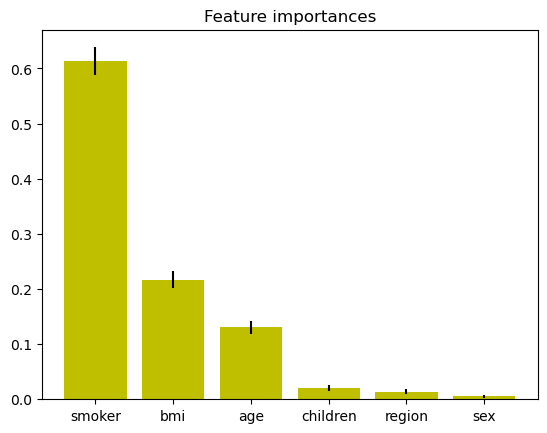

In [58]:
print('Feature importance ranking\n\n')
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = ['age', 'sex', 'bmi', 'children','smoker', 'region']
importance_list = []
for f in range(Xb.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(importance_list, importances[indices],
       color="y", yerr=std[indices], align="center")

XGBoost Regressor

In [59]:
xgboost= XGBRegressor(random_state=0)
xgboost.fit(Xx_train, yx_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [60]:
print("Statistics of xgboost model: ")
make_score(xgboost, Xx_train, Xx_test, yx_train, yx_test)

Statistics of xgboost model: 
MSE on training data is: 881.10488886254
MSE on testing data is: 4757.88870528724
R^2 score on training data is: 0.9945848736055525
R^2 score on test data is: 0.8577420329800937


In [61]:
print("Statistics of xgboost model with CV=5: ")
cv_make_score(xgboost,Xx_train, Xx_test, yx_train, yx_test)

Statistics of xgboost model with CV=5: 
MSE on train data with CV=5: [5496.86710878 5039.03444289 5203.76668005 5196.26829898 6159.45350957]
MSE on test data with CV=5: [5528.17737138 4603.40726582 4441.25451148 5546.61792844 5842.51227214]
R^2 on training data is: [0.80786289 0.7804211  0.79425218 0.81558351 0.76511828]
R^2 on test data is: [0.83521659 0.88439905 0.88375049 0.74163158 0.71165457]
Mean of MSE on training data is: 5419.078008053226
Mean of MSE on test data is: 5192.393869850873
Mean of R^2 on training data is: 0.7926475927090305
Mean of R^2 on test data is: 0.8113304531684331


Plotting Feature importance

In [62]:
xgboost.feature_importances_

array([0.01782647, 0.0046988 , 0.0239338 , 0.00791929, 0.93908894,
       0.00653263], dtype=float32)

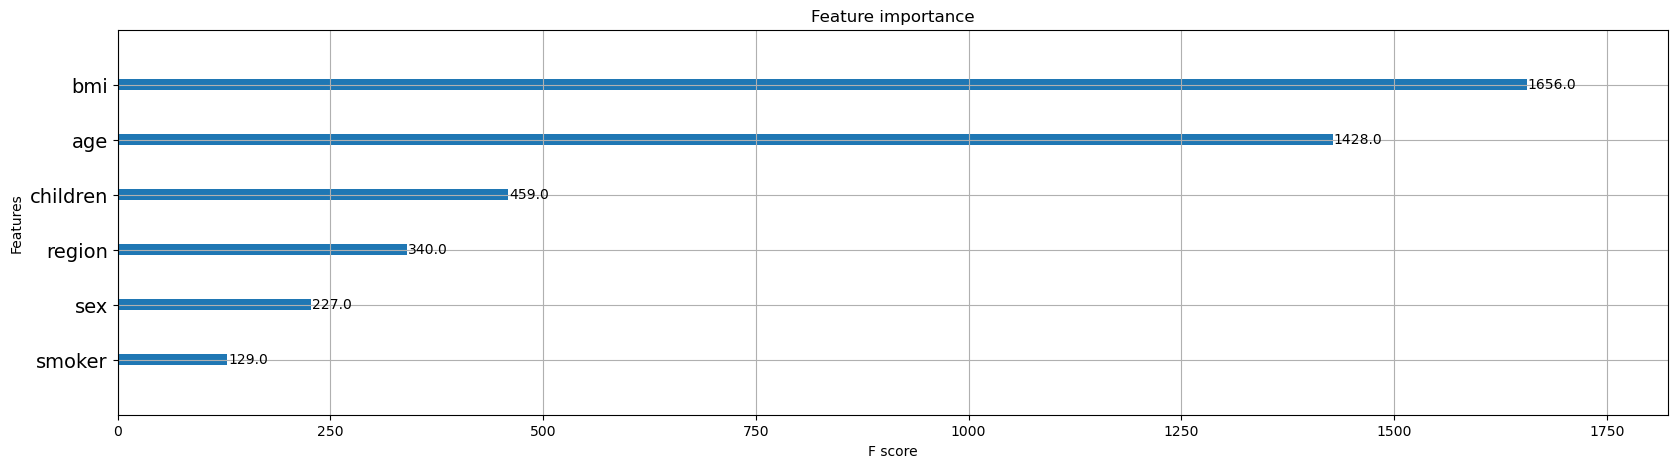

In [63]:
fig, ax = plt.subplots(figsize = (20, 5))
plot_importance(xgboost, ax = ax, max_num_features=10)
plt.yticks(fontsize = 14);

In [64]:
xgb_pipeline = Pipeline(steps=[('model', xgboost)])
# set parameters for the optimization using GridSearch
parameters = {}
parameters['model__n_estimators'] = [500, 1000, 2000]
parameters['model__max_depth'] = [3, 4, 5]
parameters['model__learning_rate'] = [0.01, 0.1, 0.05]

grid = GridSearchCV(xgb_pipeline, parameters, scoring = 'neg_mean_absolute_error', n_jobs= -1)
grid.fit(X_train, y_train)  # train model 

GridSearchCV(estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=0, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.05],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [500, 1000, 2000]},
             scoring='neg_mean_absolute_error')

In [65]:
grid.best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 1000}

In [66]:
xgboost= XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000, random_state=0, eval_metric = 'error')
xgboost.fit(Xx_train, yx_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='error', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [67]:
print("Statistics of xgboost model: ")
make_score(xgboost, Xx_train, Xx_test, yx_train, yx_test)

Statistics of xgboost model: 
MSE on training data is: 3989.7220534488656
MSE on testing data is: 3986.704643686353
R^2 score on training data is: 0.8889704297855229
R^2 score on test data is: 0.9001205449680394


In [68]:
print("Statistics of xgboost model with CV=5: ")
cv_make_score(xgboost,Xx_train, Xx_test, yx_train, yx_test)

Statistics of xgboost model with CV=5: 
MSE on train data with CV=5: [4487.48906183 4146.60892369 4733.19865275 4421.82630902 5691.22659473]
MSE on test data with CV=5: [5147.88070554 3916.9218497  4357.64256957 5016.25392365 3774.42478998]
R^2 on training data is: [0.87194764 0.85130988 0.82978059 0.86645735 0.79947127]
R^2 on test data is: [0.85710846 0.91630637 0.88808636 0.78867934 0.87965852]
Mean of MSE on training data is: 4696.069908402105
Mean of MSE on test data is: 4442.62476768833
Mean of R^2 on training data is: 0.8437933476168767
Mean of R^2 on test data is: 0.865967808873866


Lasso Regression Model

In [69]:
XT = insurance.drop(['charges'], axis = 1)
yT = insurance['charges']
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.2, random_state=0)
lasso = Lasso(alpha=0.2, fit_intercept=True, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
lasso.fit(XT_train, yT_train)
lasso.score(XT_test, yT_test)

0.7998690236224705

In [70]:
print("Statistics of Lasso model: ")
make_score(lasso, XT_train, XT_test, yT_train, yT_test)

Statistics of Lasso model: 
MSE on training data is: 6142.440964435305
MSE on testing data is: 5643.299985863456
R^2 score on training data is: 0.736830619413249
R^2 score on test data is: 0.7998690236224705


In [71]:
print("Statistics of Lasso model with CV=5: ")
cv_make_score(lasso, XT_train, XT_test, yT_train, yT_test)

Statistics of Lasso model with CV=5: 
MSE on train data with CV=5: [6089.54099378 5732.57557519 5877.89465409 6199.69379975 6934.88784015]
MSE on test data with CV=5: [7079.04575141 4605.41126558 5832.99557911 6464.1125689  4043.44156681]
R^2 on training data is: [0.7641967  0.71581868 0.7374916  0.7374832  0.70225551]
R^2 on test data is: [0.72979151 0.88429838 0.7994775  0.64908595 0.86189285]
Mean of MSE on training data is: 6166.91857259326
Mean of MSE on test data is: 5605.001346362237
Mean of R^2 on training data is: 0.7314491360906825
Mean of R^2 on test data is: 0.7849092375029807


In [72]:
insurance1.select_dtypes('object').columns.tolist()

['sex', 'smoker', 'region']

In [73]:
X1 = insurance1.drop(['charges'], axis = 1)
y1 = insurance1['charges']

#make transformer
transformer1 = make_column_transformer((OneHotEncoder(drop = 'first'), insurance1.select_dtypes('object').columns.tolist()),
                                      remainder = StandardScaler(),
                                     verbose_feature_names_out=False)


#pipeline to transform and model
pipe = Pipeline([('transform', transformer1), 
                 ('model', Lasso(alpha = 0.5))])
#fit the train data
pipe.fit(X1, y1)
#dataframe of coefficients
coef_df = pd.DataFrame({'features': pipe.named_steps['transform'].get_feature_names_out(),
          'coef': pipe.named_steps['model'].coef_}).sort_values(by = 'coef')
coef_df

coef_df[coef_df['coef'] != 0].shape[0]
positive_coefs = coef_df[coef_df['coef'] > 0]['features'].tolist()
print(len(positive_coefs))
print(positive_coefs)

negative_coefs = coef_df[coef_df['coef'] < 0]['features'].tolist()
print(len(negative_coefs))
print(negative_coefs)

insurance1.dtypes




4
['children', 'bmi', 'age', 'smoker_yes']
4
['region_southeast', 'region_southwest', 'region_northwest', 'sex_male']


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [74]:
#transform the input data
#X1 = transformer1.fit_transform(X1)


In [75]:
#X1

KMeans Clustering

/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

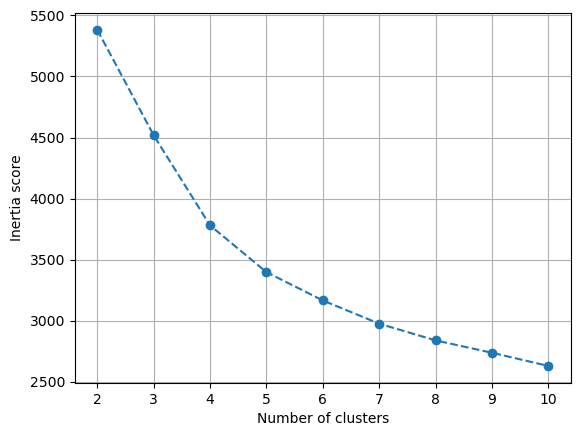

In [76]:
data_scaled = transformer1.fit_transform(insurance)

inertia_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_scaled)
    labels = kmeans.labels_
    inertia_scores.append(kmeans.inertia_)
plt.plot(range(2, 11), inertia_scores, '--o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia score')
plt.grid();

In [77]:
kmeans_5 = KMeans(n_clusters=5, random_state=22)
kmeans_5.fit(data_scaled)
print("KMeans Clustering inertia is:",kmeans_5.inertia_)
pred = kmeans_5.predict(data_scaled)
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()


KMeans Clustering inertia is: 3398.2495711048987


/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster
0    377
3    297
4    285
1    223
2    156
Name: count, dtype: int64

In [78]:
insurance2=insurance1
insurance2['label'] =  kmeans_5.labels_
insurance2.head()


,age,sex,bmi,children,smoker,region,charges,label
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,3
3,33,male,22.705,0,no,northwest,21984.47061,4
4,32,male,28.880,0,no,northwest,3866.85520,0


Neural Netwroks

In [81]:
nnet= MLPRegressor()
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, random_state=0)


In [86]:
#pipeline to transform and model
nn_pipe = Pipeline([('transform', transformer1), 
                 ('model', nnet)])

nn_pipe.fit(X1_train, y1_train)

make_score(nn_pipe, X1_train, X1_test, y1_train, y1_test)

MSE on training data is: 17270.96684326147
MSE on testing data is: 17821.864192599172
R^2 score on training data is: -1.0874792948363927
R^2 score on test data is: -1.0174664225105148


/Users/aizadanayal/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
